In [24]:
import torch
import torchvision
import time
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models, transforms
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, Linear
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import F1Score
from tqdm import tqdm
from IPython import display


from view_data import show_image
from load_data import MyDataClass, AugData, get_all_labels
from save_model import save_checkpoint, load_checkpoint
from make_submission import generate_submission

In [25]:
PATH_TO_DATA = "data/"
NUM_CLASSES = 30

Создадим словари для того, чтобы кодировать лейблы в цифры и наоборот.

In [26]:
labels = get_all_labels(PATH_TO_DATA + "train.csv")
labels_to_idx = dict()
idx_to_label = dict()
for i, label in enumerate(labels):
    labels_to_idx[label] = i
    idx_to_label[i] = label

Загружаем трейн и тест данные.

In [27]:
test_data = MyDataClass(PATH_TO_DATA, "test", labels_to_idx)
all_train_data = MyDataClass(PATH_TO_DATA, "train", labels_to_idx)

Разделим данные на обучающую и валидационную выборки.

In [28]:
train_data, val_data = torch.utils.data.random_split(all_train_data, [0.8, 0.2])

In [29]:
len(train_data)

36299

Посмотрим на несколько картинок из тренировочных данных:

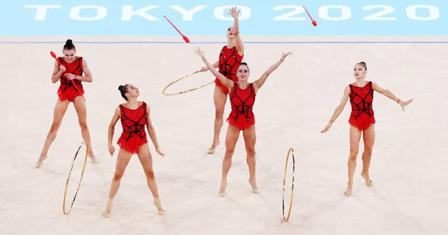

gymnastics



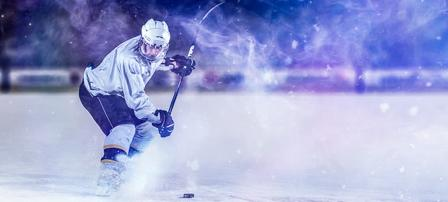

hockey



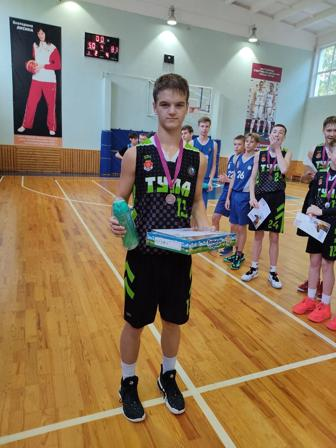

basketball



In [30]:
show_image(train_data, idx_to_label, "train", num_image_to_show = 3, transformed=False)

Преобразуем данные нужным образом и выполним аугментацию. В качестве аугментации будем использовать случайный поворот с максимальным значением 20, случайный кроп, а также будем немного менять яркость, контрастность, насыщенность и оттенок изображения.

In [31]:
normalize = torchvision.transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize((384,384), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop([384]),
    transforms.ToTensor(),
    normalize
])

transform_augmentation = transforms.Compose([
    transforms.Resize((384,384), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ColorJitter(brightness=.1, hue=.05),
    transforms.RandomRotation(20),
    transforms.RandomCrop([384]),    
    transforms.ToTensor(),
    normalize
])

train_aug = AugData(train_data, transform_augmentation)
val_tr_data = AugData(val_data, transform)
test_tr_data = AugData(test_data, transform)

Посмотрим на преобразованные и аугментированные изображения:

torch.Size([3, 384, 384])


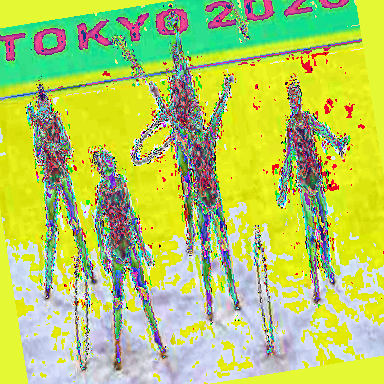

gymnastics

torch.Size([3, 384, 384])


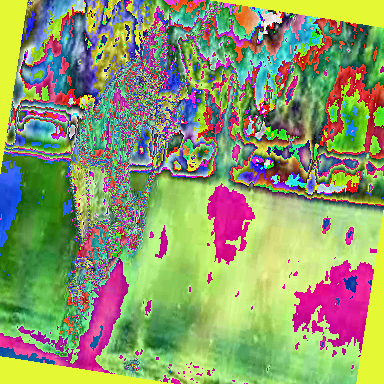

hockey

torch.Size([3, 384, 384])


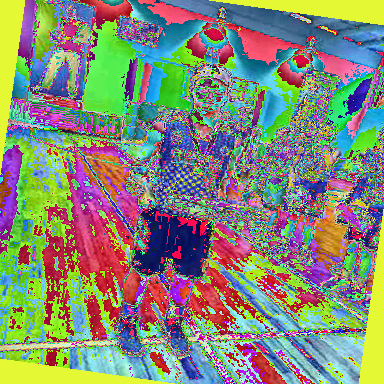

basketball



In [32]:
show_image(train_aug, idx_to_label, "train", num_image_to_show = 3, transformed=True)

Проверим, что наши датасеты остались нужной длины

In [33]:
print(f"Length of train data = {len(train_aug)}\nLength of val data = {len(val_tr_data)}")

Length of train data = 36299
Length of val data = 9074


В качестве основной модели попробуем взять Vision Transformer из библиотеки torchvision.models. Конкретно будем использовать **ViT_B_16** с весами "IMAGENET1K_SWAG_E2E_V1", поскольку такая конфигурация наиболее оптимальна по соотношению число параметров и top-1 accuracy.  
  
Стоит отметить, что были попытки использовать множество других более простых моделей. В том числе почти все виды resnet, несколько efficient net (efficientnet_b0, efficientnet_b2, efficientnet_b7, efficientnet_v2_s), а также ResNext и GoogleNet, однако ни одна из данных моделей и близко не подобралась к трансформеру. Трансформер после первой эпохи сходу показал точность почти на 10% выше, чем любая из перечисленных моделей, плюс он требовал разумное время для дообучения.  
  
Тем не менее трансформер не является какой-то серебряной пулей, решающей все проблемы. Важно сказать, что датасет сам по себе содержит мусор, некоторые картинки не соответствует своим лейблам, а кроме того, классы сами по себе несбалансированны. Решение этих проблем потенциально может серьезно улучшить качество, а в купе с трансформером вообще приблизить нас к максимально возможной точности.

Посмотрим на устройство нашей модели:

In [34]:
print(models.vit_b_16(weights="IMAGENET1K_SWAG_E2E_V1"))

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Чтобы адаптировать ее под наши нужды достаточно отключить трекинг градиентов для всех параметров и поменять голову на нужную нам: заменить на линейный слой с 768 входами и 30 выходами.

In [37]:
class ViT(Module):
    
    def __init__(self):
        super(ViT, self).__init__()
        self.model = models.vit_b_16(weights="IMAGENET1K_SWAG_E2E_V1")
        for param in self.model.parameters():
            param.requires_grad = False        
        self.model.heads = nn.Sequential(nn.Linear(768, NUM_CLASSES))
   
    def forward(self, x):
        res = self.model(x)
        return res

Выберем нужный нам девайс и проверим, что модель выдает данные в корректной форме.

In [38]:
if torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

vit = ViT()
vit.to(device)
x = torch.randn(2, 3, 384, 384).to(device)
y = vit(x)
assert y.shape == torch.Size([2, NUM_CLASSES])

In [39]:
device

device(type='mps')

In [40]:
n_epochs = 10
batch_size = 32


train_dataloader = DataLoader(train_aug, batch_size=batch_size, shuffle=True,
                              drop_last=True, pin_memory=True)
val_dataloader = DataLoader(val_tr_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True)
test_dataloader = DataLoader(test_tr_data, batch_size=batch_size, shuffle=False,
                              drop_last=False, pin_memory=True)

Напишем функцию для обучения:

In [41]:
def train_model(
    dataloders, model, criterion, optimizer, scheduler,
    train_loss, train_f1, val_loss, val_f1, n_epochs
    ):
    dataset_sizes = {"train": len(dataloders["train"].dataset), 
                     "val": len(dataloders["val"].dataset)}
    
    #  определим нужную метрику
    f1_micro = F1Score(
        task="multiclass",
        average="micro",
        num_classes=NUM_CLASSES
    ).to(device)

    for epoch in range(n_epochs):
        for mode in ["train", "val"]:
            metric_score = []
            running_loss = 0.0
            
            if mode == "train":
                model.train(True)
            else:
                model.train(False)

            for i, batch in enumerate(tqdm(dataloders[mode])):

                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)

                # посчитаем лосс
                loss = criterion(outputs, labels)
                
                #  найдем предсказанный класс
                pred_labels = outputs.max(dim = 1)[1]
                pred_labels = pred_labels.to(device)

                if mode == "train":
                    loss.backward()
                    optimizer.step()
                    
                if i == 0:
                    all_labels = labels
                    all_pred_labels = pred_labels
                else:
                    all_labels = torch.cat((all_labels,labels))
                    all_pred_labels = torch.cat((all_pred_labels, pred_labels))
                
                metric_score.append(f1_micro(labels, pred_labels))
                running_loss += loss.item()
            
            #  счиатем метрики и лосс
            if mode == "train":
                scheduler.step()
                train_epoch_loss = running_loss / dataset_sizes[mode]
                train_epoch_f1 = f1_micro(all_labels, all_pred_labels)
                train_loss.append(train_epoch_loss)
                train_f1.append(train_epoch_f1)
            else:
                valid_epoch_loss = running_loss / dataset_sizes[mode]
                val_epoch_f1 = f1_micro(all_labels, all_pred_labels)
                val_loss.append(valid_epoch_loss)
                val_f1.append(val_epoch_f1)
                
        print(f"Epoch [{epoch + 1}/{n_epochs}]")
        print(f"\ttrain loss = {train_epoch_loss}")
        print(f"\ttrain f-1 = {train_epoch_f1}")
        print(f"\tval loss = {valid_epoch_loss}")
        print(f"\tval f-1 = {val_epoch_f1}")

    return model

In [42]:
vit = ViT()
vit.to(device)

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

dataloaders = {"train":train_dataloader, "val":val_dataloader}

In [ ]:
train_loss = []
train_f1 = []
val_loss = []
val_f1 = []

start_time = time.time()
vit = train_model(dataloaders, vit, loss_func, opt, exp_lr_scheduler, train_loss, train_f1, val_loss, val_f1, n_epochs=n_epochs)
print(f"Training time: {(time.time() - start_time) / 60} minutes")

In [104]:
def plot_train_process(train_loss, train_f1, val_loss, val_f1):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label=  'test')
    axes[0].legend()

    train_f1 = [elem.to("cpu") for elem in train_f1]
    val_f1 = [elem.to("cpu") for elem in val_f1]
    axes[1].set_title('F-1')
    axes[1].plot(train_f1, label='train')
    axes[1].plot(val_f1, label='test')
    axes[1].legend()
    plt.show()

Посмотрим на графики лосса и метрики F-1:

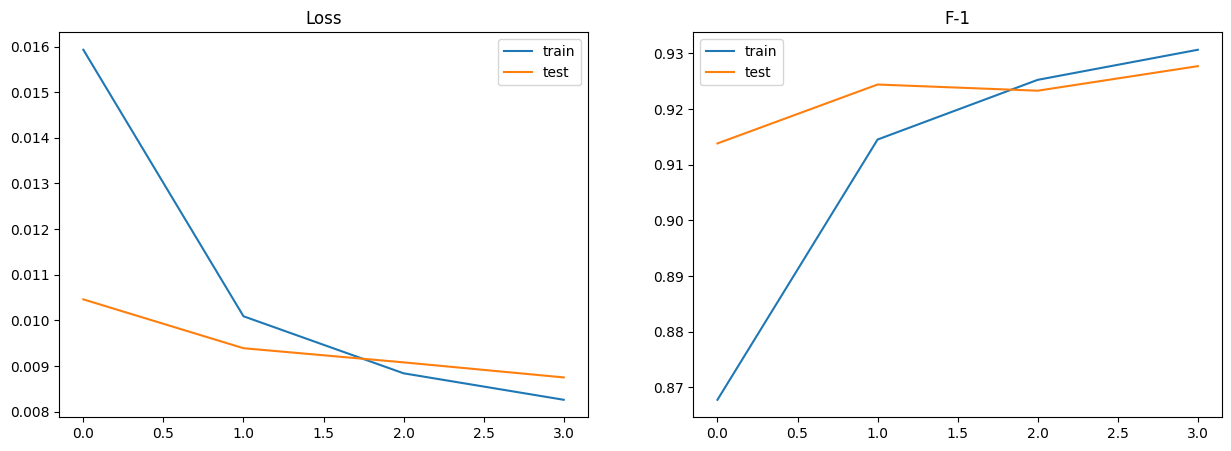

In [105]:
plot_train_process(train_loss, train_f1, val_loss, val_f1)

Сохраним параметры модели и сгененируем submission файл.

In [ ]:
save_checkpoint('/content/drive/MyDrive/made-cv-dataset/model_states/TRANSFORMER', vit, opt)
generate_submission(test_dataloader, vit, idx_to_label, "submission_transformer.csv", device)